# 뉴스기사의 카테고리 판정하기

## TF-IDF 모듈 만들기

tfidf.py

In [ ]:
# TF-IDF로 텍스트를 벡터로 변환하는 모듈
from konlpy.tag import Okt
import pickle
import numpy as np

# KoNLPy의 Okt객체 초기화
okt = Okt()
# 전역 변수 
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트

def tokenize(text):
    '''KoNLPy로 형태소 분석하기''' 
    result = []
    word_s = okt.pos(text, norm=True, stem=True)
    for n, h in word_s:
        if not (h in ['Noun', 'Verb ', 'Adjective']): continue
        if h == 'Punctuation' and h2 == 'Number': continue
        result.append(n)
    return result

def words_to_ids(words, auto_add = True):
    ''' 단어를 ID로 변환하기 ''' 
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result

def add_text(text):
    '''텍스트를 ID 리스트로 변환해서 추가하기''' 
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def add_file(path):
    '''텍스트 파일을 학습 전용으로 추가하기''' 
    with open(path, "r", encoding="utf-8") as f:
        s = f.read()
        add_text(s)

def calc_files():
    '''추가한 파일 계산하기''' 
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    # 단어 출현 횟수 세기 
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
        # 단어 t가 사용되고 있을 경우 dt_dic의 수를 1 더하기
        for id in used_word:
            if not(id in dt_dic): dt_dic[id] = 0
            dt_dic[id] += 1
        # 정규화하기 
        data = data / len(words) 
        result.append(data)
    # TF-IDF 계산하기 
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id]) + 1
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

def save_dic(fname):
    '''사전을 파일로 저장하기''' 
    pickle.dump(
        [word_dic, dt_dic, files],
        open(fname, "wb"))

def load_dic(fname):
    '''사전 파일 읽어 들이기''' 
    global word_dic, dt_dic, files
    n = pickle.load(open(fname, 'rb'))
    word_dic, dt_dic, files = n

def calc_text(text):
    ''' 문장을 벡터로 변환하기 ''' 
    data = np.zeros(word_dic['_id'])
    words = words_to_ids(tokenize(text), False)
    for w in words:
        data[w] += 1
    data = data / len(words)
    for id, v in enumerate(data):
        idf = np.log(len(files) / dt_dic[id]) + 1
        data[id] = min([data[id] * idf, 1.0])
    return data
# 모듈 테스트하기 
if __name__ == '__main__':
    add_text('비')
    add_text('오늘은 비가 내렸어요.') 
    add_text('오늘은 더웠지만 오후부터 비가 내렸다.') 
    add_text('비가 내리는 일요일이다.') 
    print(calc_files())
    print(word_dic)

## 텍스트 분류하기

makedb_tfid.py

In [ ]:
import os, glob, pickle
import tfidf

# 변수 초기화
y = []
x = []

# 디렉터리 내부의 파일 목록 전체에 대해 처리하기
def read_files(path, label):
    print("read_files=", path)
    files = glob.glob(path + "/*.txt")
    for f in files:
        if os.path.basename(f) == 'LICENSE.txt': continue
        tfidf.add_file(f)
        y.append(label)

# 기사를 넣은 디렉터리 읽어 들이기
read_files('text/100', 0)
read_files('text/101', 1)
read_files('text/103', 2)
read_files('text/105', 3)


# TF-IDF 벡터로 변환하기
x = tfidf.calc_files()

# 저장하기
pickle.dump([y, x], open('text/genre.pickle', 'wb'))
tfidf.save_dic('text/genre-tdidf.dic')
print('ok')


## TF-IDF를 나이브 베이즈로 학습시키기

In [16]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

# TF-IDF 데이터베이스 읽어 들이기 
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0] # 레이블
x = data[1] # TF-IDF

# 학습 전용과 테스트 전용으로 구분하기
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2)

# 나이브 베이즈로 학습하기
model = GaussianNB()
model.fit(x_train, y_train)

# 평가하고 결과 출력하기
y_pred = model.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
rep = metrics.classification_report(y_test, y_pred)

print("정답률=", acc)
print(rep)

정답률= 0.8390625
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       170
           1       0.87      0.68      0.76       146
           2       0.76      0.90      0.82       172
           3       0.82      0.85      0.83       152

    accuracy                           0.84       640
   macro avg       0.85      0.83      0.84       640
weighted avg       0.85      0.84      0.84       640



## 딥러닝으로 정답률 개선하기

Train on 2557 samples, validate on 640 samples
Epoch 1/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.8509 - acc: 0.7478 - val_loss: 0.3926 - val_acc: 0.8844
Epoch 2/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.2494 - acc: 0.9222 - val_loss: 0.3113 - val_acc: 0.8891
Epoch 3/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.1091 - acc: 0.9664 - val_loss: 0.2812 - val_acc: 0.8969
Epoch 4/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0462 - acc: 0.9894 - val_loss: 0.2955 - val_acc: 0.9031
Epoch 5/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0223 - acc: 0.9934 - val_loss: 0.3363 - val_acc: 0.8969
Epoch 6/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0114 - acc: 0.9977 - val_loss: 0.3783 - val_acc: 0.8906
Epoch 7/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0071 - acc: 0.9973 - val_loss: 0.3728 - val_acc: 0.9016
Epoch 8/20
2557

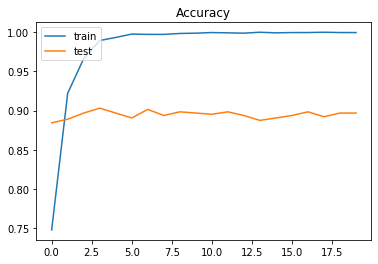

In [18]:
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py

# 분류할 레이블 수
nb_classes = 4

# 데이터베이스 읽어 들이기 
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0] # 레이블
x = data[1] # TF-IDF
# 레이블 데이터를 One-hot 형식으로 변환하기
y = keras.utils.np_utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0]

# 학습 전용과 테스트 전용으로 구분하기 
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# MLP모델의 구조 정의하기
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

# 모델 컴파일하기 
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 학습 실행하기 
hist = model.fit(x_train, y_train,
          batch_size=128, 
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))

# 평가하기 
score = model.evaluate(x_test, y_test, verbose=1)
print("정답률=", score[1], 'loss=', score[0])

# 가중치데이터 저장하기
model.save_weights('./text/genre-model.hdf5')

# 학습 상태를 그래프로 그리기 
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 직접 문장을 지정해 판정하기

my_text.py

In [ ]:
import pickle, tfidf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.models import model_from_json

# 텍스트 준비하기
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
iPhone과 iPad를 모두 가지고 다니므로 USB를 2개 연결할 수 있는 휴대용 배터리를 선호합니다.
"""
text3 = """
이번 주에는 미세먼지가 많을 것으로 예상되므로 노약자는 외출을 자제하는 것이 좋습니다.
"""

# TF-IDF 사전 읽어 들이기
tfidf.load_dic("text/genre-tdidf.dic")

# Keras 모델 정의하고 가중치 데이터 읽어 들이기
nb_classes = 4
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(52800,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])
model.load_weights('./text/genre-model.hdf5')

# 텍스트 지정해서 판별하기 
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치", "경제", "생활 ", "IT/과학"]
    # TF-IDF 벡터로 변환하기 
    data = tfidf.calc_text(text)
    # MLP로 예측하기 
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)

# 머신러닝에서 데이터베이스 사용하기

## SQLite로 키와 체중 데이터베이스 만들기 

In [3]:
import sqlite3

dbpath = "./hw.sqlite3"
sql = '''
  CREATE TABLE IF NOT EXISTS person (
      id INTEGER PRIMARY KEY,
      height NUMBER,
      weight NUMBER,
      typeNo INTEGER
  )
'''
with sqlite3.connect(dbpath) as conn:
    conn.execute(sql)

## 새로운 키와 체중을 데이터베이스에 추가하기

In [80]:
import sqlite3
import random

dbpath = "./hw.sqlite3"

def insert_db(conn):
    # 더미 데이터 만들기 --- (*1)
    height = random.randint(130, 180)
    weight = random.randint(30, 100)
    # 더미 데이터를 기반으로 체형 데이터 생성하기 --- (*2)
    type_no = 1
    bmi = weight / (height / 100) ** 2
    if bmi < 18.5:
        type_no = 0
    elif bmi < 25:
        type_no = 1
    elif bmi < 30:
        type_no = 2
    elif bmi < 35:
        type_no = 3
    elif bmi < 40:
        type_no = 4
    else:
        type_no = 5
    # 데이터베이스에 저장하기 --- (*3)
    sql = '''
      INSERT INTO person (height, weight, typeNo) 
      VALUES (?,?,?)
    '''
    values = (height,weight, type_no)
    print(values)
    conn.executemany(sql,[values])

# 100개의 데이터 삽입하기
with sqlite3.connect(dbpath) as conn:
    # 데이터 100개 삽입하기 --- (*4)
    for i in range(100):
        insert_db(conn)
    # 확인하기 --- (*5)
    c = conn.execute('SELECT count(*) FROM person')
    cnt = c.fetchone()
    print(cnt[0])

(156, 69, 2)
(140, 55, 2)
(171, 61, 1)
(165, 77, 2)
(161, 99, 4)
(164, 99, 4)
(175, 81, 2)
(145, 55, 2)
(149, 86, 4)
(159, 42, 0)
(157, 70, 2)
(144, 35, 0)
(180, 97, 2)
(177, 44, 0)
(145, 79, 4)
(169, 37, 0)
(136, 79, 5)
(143, 45, 1)
(156, 41, 0)
(140, 55, 2)
(146, 100, 5)
(175, 30, 0)
(169, 66, 1)
(148, 80, 4)
(172, 49, 0)
(139, 32, 0)
(177, 97, 3)
(174, 83, 2)
(167, 96, 3)
(138, 91, 5)
(144, 37, 0)
(130, 62, 4)
(159, 73, 2)
(163, 78, 2)
(163, 34, 0)
(137, 88, 5)
(156, 54, 1)
(131, 90, 5)
(132, 92, 5)
(137, 76, 5)
(143, 85, 5)
(150, 70, 3)
(144, 71, 3)
(152, 77, 3)
(180, 80, 1)
(165, 99, 4)
(166, 45, 0)
(141, 87, 5)
(176, 57, 0)
(180, 34, 0)
(165, 66, 1)
(176, 59, 1)
(143, 34, 0)
(153, 31, 0)
(130, 45, 2)
(174, 91, 3)
(160, 66, 2)
(134, 77, 5)
(138, 63, 3)
(170, 60, 1)
(172, 88, 2)
(156, 81, 3)
(160, 97, 4)
(140, 44, 1)
(140, 59, 3)
(177, 91, 2)
(135, 68, 4)
(147, 40, 1)
(158, 60, 1)
(152, 84, 4)
(149, 86, 4)
(149, 47, 1)
(149, 43, 1)
(158, 85, 3)
(154, 58, 1)
(154, 55, 1)
(164, 71, 2

In [81]:
import sqlite3

dbpath = "./hw.sqlite3"
select_sql = "SELECT * FROM person"

with sqlite3.connect(dbpath) as conn:
    for row in conn.execute(select_sql):
        print(row)

(1, 138, 76, 4)
(2, 130, 86, 5)
(3, 158, 89, 4)
(4, 174, 90, 2)
(5, 145, 92, 5)
(6, 130, 87, 5)
(7, 137, 94, 5)
(8, 179, 94, 2)
(9, 167, 98, 4)
(10, 151, 52, 1)
(11, 151, 34, 0)
(12, 160, 60, 1)
(13, 180, 53, 0)
(14, 174, 71, 1)
(15, 170, 78, 2)
(16, 161, 77, 2)
(17, 158, 93, 4)
(18, 173, 94, 3)
(19, 137, 56, 2)
(20, 154, 32, 0)
(21, 147, 83, 4)
(22, 162, 59, 1)
(23, 147, 34, 0)
(24, 157, 68, 2)
(25, 168, 53, 1)
(26, 173, 66, 1)
(27, 178, 44, 0)
(28, 149, 92, 5)
(29, 131, 33, 1)
(30, 133, 49, 2)
(31, 154, 67, 2)
(32, 164, 99, 4)
(33, 147, 38, 0)
(34, 177, 74, 1)
(35, 139, 46, 1)
(36, 154, 65, 2)
(37, 141, 60, 3)
(38, 143, 98, 5)
(39, 135, 65, 4)
(40, 174, 57, 1)
(41, 143, 77, 4)
(42, 170, 42, 0)
(43, 175, 99, 3)
(44, 149, 55, 1)
(45, 153, 99, 5)
(46, 139, 98, 5)
(47, 170, 88, 3)
(48, 145, 59, 2)
(49, 140, 96, 5)
(50, 140, 100, 5)
(51, 146, 84, 4)
(52, 136, 43, 1)
(53, 178, 74, 1)
(54, 177, 53, 0)
(55, 172, 93, 3)
(56, 165, 73, 2)
(57, 136, 91, 5)
(58, 145, 93, 5)
(59, 130, 76, 5)
(60, 

## 키, 체중, 체형 학습하기

In [82]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

in_size = 2 # 체중과 키를 입력으로
nb_classes = 6 # 체형은 6단계로 구별

# MLP모델의 구조 정의하기
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# 모델 컴파일하기
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

model.save('hw_model.h5')
print("saved")

saved


In [83]:
import keras
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import numpy as np
import sqlite3
import os

# 데이터베이스에서 데이터 100개 읽어들이기
dbpath = './hw.sqlite3'
select_sql = 'SELECT * FROM person ORDER BY id DESC LIMIT 100'

# 읽어 들인 데이터를 리스트에 추가하기
x = []
y = []
with sqlite3.connect(dbpath) as conn:
    for row in conn.execute(select_sql):
        id, height, weight, type_no = row
        # 데이터 정규화하기
        height = height / 200
        weight = weight / 150
        y.append(type_no)
        x.append(np.array([height, weight]))
        
# 모델 읽어들이기
model = load_model('hw_model.h5')

# 이미 학습 데이터가 있는 경우 읽어 들이기 
if os.path.exists('hw_weights.h5'):
    model.load_weights('hw_weights.h5')

nb_classes = 6 # 체형은 6단계로 구별
y = to_categorical(y, nb_classes) # One-hot 벡터로 변환하기

# 학습하기
model.fit(np.array(x), y,
    batch_size=50,
    epochs=100)

# 결과 저장하기 
model.save_weights('hw_weights.h5')

Epoch 1/100
100/100 [==============================] - 1s 10ms/step - loss: 0.3655 - acc: 0.8900
Epoch 2/100
100/100 [==============================] - 0s 100us/step - loss: 0.3863 - acc: 0.8900
Epoch 3/100
100/100 [==============================] - 0s 100us/step - loss: 0.3470 - acc: 0.8900
Epoch 4/100
100/100 [==============================] - 0s 100us/step - loss: 0.3582 - acc: 0.8700
Epoch 5/100
100/100 [==============================] - 0s 120us/step - loss: 0.3989 - acc: 0.8500
Epoch 6/100
100/100 [==============================] - 0s 90us/step - loss: 0.3593 - acc: 0.8900
Epoch 7/100
100/100 [==============================] - 0s 100us/step - loss: 0.3781 - acc: 0.9000
Epoch 8/100
100/100 [==============================] - 0s 110us/step - loss: 0.3733 - acc: 0.9000
Epoch 9/100
100/100 [==============================] - 0s 120us/step - loss: 0.3548 - acc: 0.9100
Epoch 10/100
100/100 [==============================] - 0s 90us/step - loss: 0.3759 - acc: 0.8800
Epoch 11/100
100/100 [

## 정답률 확인하기

In [84]:
from keras.models import load_model
import numpy as np

# 학습하기모델 읽어 들이기 
model = load_model('hw_model.h5')
# 학습한 데이터 읽어 들이기
model.load_weights('hw_weights.h5')
# 레이블
LABELS = [
    '저체중', '표준 체중 ', '1비만(1도)',
    '비만(2도)', '비만(3도)', '비만(4도)' 
]

# 테스트 데이터 지정하기
height = 160
weight = 50
# 정규화하기 
test_x = [height / 200, weight / 150]
# 예측하기 
pre = model.predict(np.array([test_x]))
idx = pre[0].argmax()
print(LABELS[idx], '/ 가능성', pre[0][idx])

표준 체중  / 가능성 0.7111527


## 분류 정답률 구하기

In [85]:
from keras.models import load_model
import numpy as np
import random
from keras.utils.np_utils import to_categorical

# 학습하기모델 읽어 들이기
model = load_model('hw_model.h5')
# 학습한 데이터 읽어 들이기 
model.load_weights('hw_weights.h5')

# 정답 데이터를 1000개 만들기
x = []
y = []
for i in range(1000):
    h = random.randint(130, 180)
    w = random.randint(30, 100)
    bmi = w / ((h / 100) ** 2)
    type_no = 1
    if bmi < 18.5:
        type_no = 0
    elif bmi < 25:
        type_no = 1
    elif bmi < 30:
        type_no = 2
    elif bmi < 35:
        type_no = 3
    elif bmi < 40:
        type_no = 4
    else:
        type_no = 5
    x.append(np.array([h / 200, w / 150]))
    y.append(type_no)

# 형식 변환하기
x = np.array(x)
y = to_categorical(y, 6)
# 정답률 확인하기 
score = model.evaluate(x, y, verbose=1)
print("정답률=", score[1], "손실 =", score[0])

1000/1000 [==============================] - 0s 420us/step
정답률= 0.921 손실 = 0.32061712694168093
